## 1. Plotting the Data

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(context="notebook", style="whitegrid", palette="dark")

In [3]:
data = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'result'])
data.head()

,test1,test2,result
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


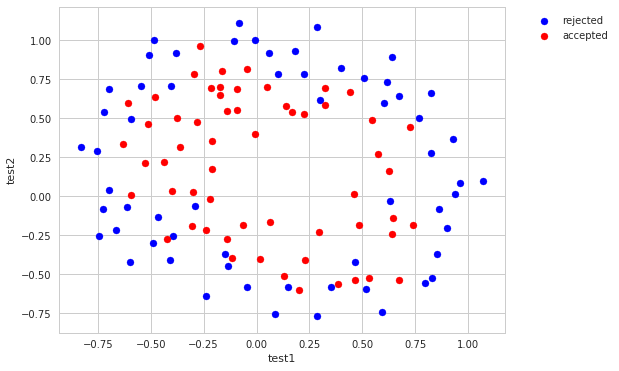

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

tp1 = data.query('result == 0')
tp1x1 = tp1.iloc[:, 0:1].as_matrix()
tp1x2 = tp1.iloc[:, 1:2].as_matrix()
st1 = ax.scatter(tp1x1, tp1x2, c='blue')

tp2 = data.query('result == 1')
tp2x1 = tp2.iloc[:, 0:1].as_matrix()
tp2x2 = tp2.iloc[:, 1:2].as_matrix()
st2 = ax.scatter(tp2x1, tp2x2, c='red')

ax.legend((st1, st2), ('rejected', 'accepted'), loc=0, bbox_to_anchor=(1.25, 1))
ax.set_xlabel('test1')
ax.set_ylabel('test2')
plt.show()

## 2. Feature mapping

对于非线性模型边界分割，必须在原始数据上做一些非线性变换。比如把X做平方项，X1 * X2等

![avatar](img/3.png)

In [5]:
def feature_mapping(x, y, power):
    data = {}
    # # inclusive
    for i in np.arange(power + 1):
        for p in np.arange(i + 1):
            data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)
    return pd.DataFrame(data)


x1 = np.array(data.test1)
x2 = np.array(data.test2)
dt = feature_mapping(x1, x2, 6)
print dt.shape
dt.head()

(118, 28)


,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
0,1.0,0.69956,0.489384,0.342354,0.239497,0.167542,0.117206,0.051267,0.035864,0.025089,...,0.000135,0.000094,0.000066,0.000046,0.000007,0.000005,0.000003,3.541519e-07,2.477505e-07,1.815630e-08
1,1.0,0.68494,0.469143,0.321335,0.220095,0.150752,0.103256,-0.092742,-0.063523,-0.043509,...,-0.000798,-0.000546,-0.000374,-0.000256,0.000074,0.000051,0.000035,-6.860919e-06,-4.699318e-06,6.362953e-07
2,1.0,0.69225,0.479210,0.331733,0.229642,0.158970,0.110047,-0.213710,-0.147941,-0.102412,...,-0.009761,-0.006757,-0.004677,-0.003238,0.002086,0.001444,0.001000,-4.457837e-04,-3.085938e-04,9.526844e-05
3,1.0,0.50219,0.252195,0.126650,0.063602,0.031940,0.016040,-0.375000,-0.188321,-0.094573,...,-0.052734,-0.026483,-0.013299,-0.006679,0.019775,0.009931,0.004987,-7.415771e-03,-3.724126e-03,2.780914e-03
4,1.0,0.46564,0.216821,0.100960,0.047011,0.021890,0.010193,-0.513250,-0.238990,-0.111283,...,-0.135203,-0.062956,-0.029315,-0.013650,0.069393,0.032312,0.015046,-3.561597e-02,-1.658422e-02,1.827990e-02


## 3. Regularized cost

![avatar](img/4.png)

In [6]:
def sigmoid(theta, X):
    """
    @param X: 样本集; m*n的矩阵，m为样本个数，n为样本特征个数，其中x0 = 1
    @param theta: 带求解的最佳θ; n维向量
    """
    z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))


# 代价函数
def cost(theta, X, Y):
    """
    @param X: 样本集; m*n的矩阵，m为样本个数，n为样本特征个数，其中x0 = 1
    @param Y: 样本结果;m维向量
    @param theta: 带求解的最佳θ; n维向量
    """
    m, n = X.shape
    return -(np.dot(Y, np.log(sigmoid(theta, X))) + np.dot((1 - Y), np.log(1 - sigmoid(theta, X))))/ m


def regularizedCost(theta, X, Y, lmd=1):
    inner_theta = theta[1:]
    m, n = X.shape
    return cost(theta, X, Y) + np.power(inner_theta, 2).sum() * (lmd / 2 * m)

## 4. Regularized gradient

![avatar](img/5.png)

In [20]:
# 梯度函数
def gradient(theta, X, Y):
    m, n = np.shape(X)
    # m维向量
    inner = sigmoid(theta, X) - Y
    # n维向量
    return np.dot(X.T, inner) / m


def regularizedGradient(theta, X, Y, lmd=1):
    m, n = X.shape
    regularized_theta = (lmd / m) * theta[1:]
    regularized_theta = np.concatenate([np.zeros(1), regularized_theta])
    return gradient(theta, X, Y) + regularized_theta

In [30]:
import scipy.optimize as opt


# X feature mapping
X = feature_mapping(x1, x2, 6).as_matrix()
# 获取Y
Y = np.array(data.iloc[:, -1])
# 初始化theta
theta = np.zeros(X.shape[1])
lmd = 1

ret = opt.minimize(fun=regularizedCost, 
                   x0=theta, args=(X, Y, lmd), 
                   method='Newton-CG',
                   jac=regularizedGradient)
print ret
final_theta = ret.x

     fun: 0.2629784673149784
     jac: array([  2.52643470e-04,   4.74623924e-04,   5.95541255e-04,
         3.39440132e-04,   4.25272902e-04,   3.41879430e-04,
         3.97485313e-04,   8.04087329e-05,   3.58373171e-04,
         8.22543668e-05,   3.35743914e-05,  -3.56904764e-05,
        -4.36141695e-05,   6.30617221e-04,   2.47979626e-04,
         2.17914480e-04,   8.46624162e-05,   7.64010215e-05,
         2.34681148e-04,   1.70807109e-04,   9.40534668e-05,
         4.16997948e-05,   3.62262925e-04,   1.38997247e-04,
         1.07311425e-04,   1.48251293e-04,   9.00930801e-05,
         2.02995696e-04])
 message: "Warning: CG iterations didn't converge.  The Hessian is not positive definite."
    nfev: 13
    nhev: 0
     nit: 12
    njev: 2503
  status: 3
 success: False
       x: array([   6.43857276,    3.59761025,  -16.28045281,    4.50706652,
          7.58128546,    4.43789411,  -17.16777722,    3.83373862,
        -24.55695501,   19.19107849,   53.07321008,  -26.96347031,
   

## 5. Decision boundary

(412, 28)


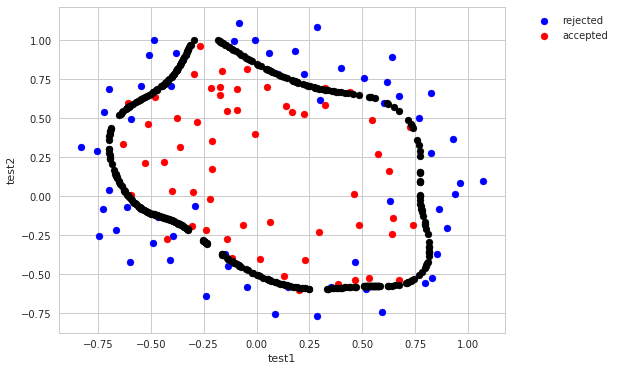

In [11]:
t1 = np.linspace(-1, 1, 1000)
t2 = np.linspace(-1, 1, 1000)

#-1 -- 1之间的所有点
cordinates = [(x, y) for x in t1 for y in t2]
x, y = zip(*cordinates)
dt = feature_mapping(x, y, 6)
X = dt.as_matrix()
predict = np.dot(X, final_theta)
# 过滤掉预测结果小于0.005的点，值越小越精确
decision = dt[np.abs(predict) < 0.005]
print decision.shape


fig, ax = plt.subplots(figsize=(8, 6))
st1 = ax.scatter(tp1x1, tp1x2, c='blue')
st2 = ax.scatter(tp2x1, tp2x2, c='red')
st3 = ax.scatter(decision.f10, decision.f01, c='black')

ax.legend((st1, st2), ('rejected', 'accepted'), loc=0, bbox_to_anchor=(1.25, 1))
ax.set_xlabel('test1')
ax.set_ylabel('test2')
plt.show()